# Independent Game Interaction Prediction 
## Linear Regression

In [339]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import random
from collections import defaultdict
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


%pylab inline
#% config InlineBackend.figure_format = 'svg'

sns.set()

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score

Populating the interactive namespace from numpy and matplotlib


In [340]:
steam_df = pd.read_csv('steam_cleaned_data.csv')




In [341]:
steam_df.head(2)



,name_y,Positive_Reviews,Negative_Reviews,Approx_Owners,Average_Daily_Players,average_2weeks,Median_Daily_Players,median_2weeks,Current_Price,Initial_Price,...,Platforms,Single_or_Multiplayer,Has_Game_Trailer,Has_Achievements,release_year,Self_published,Is_Indie,Game_Genre,Number_Languages,Number_Platforms
0,Counter-Strike,124534,3339,10000000,17612,709,317,26,999.0,999.0,...,"{'windows': True, 'mac': True, 'linux': True}",Multi-player,0,0,2000.0,1,0,Action,12,3
1,Team Fortress Classic,3318,633,5000000,277,15,62,15,499.0,499.0,...,"{'windows': True, 'mac': True, 'linux': True}",Multi-player,0,0,1999.0,1,0,Action,13,3


## EDA

In [342]:
steam_df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27755 entries, 0 to 27754
Data columns (total 23 columns):
name_y                   27755 non-null object
Positive_Reviews         27755 non-null int64
Negative_Reviews         27755 non-null int64
Approx_Owners            27755 non-null int64
Average_Daily_Players    27755 non-null int64
average_2weeks           27755 non-null int64
Median_Daily_Players     27755 non-null int64
median_2weeks            27755 non-null int64
Current_Price            27755 non-null float64
Initial_Price            27755 non-null float64
Discount_Percent         27755 non-null float64
Daily_Players            27755 non-null int64
Required_Age             27755 non-null float64
Platforms                27755 non-null object
Single_or_Multiplayer    27755 non-null object
Has_Game_Trailer         27755 non-null int64
Has_Achievements         27755 non-null int64
release_year             27755 non-null float64
Self_published           27755 non-null int64
Is_I

In [343]:
steam_df.columns



Index(['name_y', 'Positive_Reviews', 'Negative_Reviews', 'Approx_Owners',
       'Average_Daily_Players', 'average_2weeks', 'Median_Daily_Players',
       'median_2weeks', 'Current_Price', 'Initial_Price', 'Discount_Percent',
       'Daily_Players', 'Required_Age', 'Platforms', 'Single_or_Multiplayer',
       'Has_Game_Trailer', 'Has_Achievements', 'release_year',
       'Self_published', 'Is_Indie', 'Game_Genre', 'Number_Languages',
       'Number_Platforms'],
      dtype='object')

In [344]:
steam_df = steam_df.rename(columns={'name_y':'Game_Name'})
steam_df['Interactions'] = steam_df['Positive_Reviews'] + steam_df['Negative_Reviews']



In [345]:
steam_df = steam_df.drop(columns=['Positive_Reviews', 'Negative_Reviews'])
steam_df.columns



Index(['Game_Name', 'Approx_Owners', 'Average_Daily_Players', 'average_2weeks',
       'Median_Daily_Players', 'median_2weeks', 'Current_Price',
       'Initial_Price', 'Discount_Percent', 'Daily_Players', 'Required_Age',
       'Platforms', 'Single_or_Multiplayer', 'Has_Game_Trailer',
       'Has_Achievements', 'release_year', 'Self_published', 'Is_Indie',
       'Game_Genre', 'Number_Languages', 'Number_Platforms', 'Interactions'],
      dtype='object')

In [346]:
# REMOVED discount percent because it is just a calculation of 1 - current/initial

steam_df = steam_df[['Game_Name', 'Interactions','Approx_Owners', 'Average_Daily_Players',
       'Median_Daily_Players', 'Current_Price', 'Initial_Price',
       'Daily_Players', 'Required_Age',
       'Single_or_Multiplayer', 'Has_Game_Trailer', 'Has_Achievements',
       'release_year', 'Is_Indie', 'Game_Genre', 'Number_Languages',
       'Number_Platforms']]



In [347]:
steam_df = steam_df.set_index(['Game_Name'])



In [348]:
steam_df.shape



(27755, 16)

In [349]:
# filter down to last two years of games released (2018, 2017)

two_years_steam_df = steam_df[(steam_df['release_year'] == 2017) | (steam_df['release_year'] == 2018)]



In [350]:
two_years_steam_df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 14817 entries, GROUND BRANCH to Roulette Simulator 2
Data columns (total 16 columns):
Interactions             14817 non-null int64
Approx_Owners            14817 non-null int64
Average_Daily_Players    14817 non-null int64
Median_Daily_Players     14817 non-null int64
Current_Price            14817 non-null float64
Initial_Price            14817 non-null float64
Daily_Players            14817 non-null int64
Required_Age             14817 non-null float64
Single_or_Multiplayer    14817 non-null object
Has_Game_Trailer         14817 non-null int64
Has_Achievements         14817 non-null int64
release_year             14817 non-null float64
Is_Indie                 14817 non-null int64
Game_Genre               14817 non-null object
Number_Languages         14817 non-null int64
Number_Platforms         14817 non-null int64
dtypes: float64(4), int64(10), object(2)
memory usage: 1.9+ MB


In [351]:
# Checking to make sure I still have enough data left
two_years_steam_df['release_year'].value_counts()

2018.0    8341
2017.0    6476
Name: release_year, dtype: int64

In [352]:
two_years_steam_df = pd.get_dummies(two_years_steam_df, drop_first=True)

In [353]:
two_years_steam_df.head()

,Interactions,Approx_Owners,Average_Daily_Players,Median_Daily_Players,Current_Price,Initial_Price,Daily_Players,Required_Age,Has_Game_Trailer,Has_Achievements,...,Single_or_Multiplayer_Multi-player,Single_or_Multiplayer_Online Co-op,Single_or_Multiplayer_Online Multi-Player,Single_or_Multiplayer_Single-player,Game_Genre_Adventure,Game_Genre_Casual,Game_Genre_None,Game_Genre_RPG,Game_Genre_Racing,Game_Genre_Strategy
Game_Name,,,,,,,,,,,,,,,,,,,,,
GROUND BRANCH,742,20000,0,0,1999.0,1999.0,14,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
Overgrowth,4515,500000,777,1365,2999.0,2999.0,37,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
AirMech Strike,9080,1000000,441,172,0.0,0.0,53,0.0,1,1,...,0,0,0,1,0,0,0,0,0,0
Secret World Legends,6526,1000000,645,408,0.0,0.0,233,0.0,1,0,...,1,0,0,0,0,0,0,0,0,0
Closers,2795,500000,194,283,0.0,0.0,904,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [354]:
two_years_steam_df.corr()

,Interactions,Approx_Owners,Average_Daily_Players,Median_Daily_Players,Current_Price,Initial_Price,Daily_Players,Required_Age,Has_Game_Trailer,Has_Achievements,...,Single_or_Multiplayer_Multi-player,Single_or_Multiplayer_Online Co-op,Single_or_Multiplayer_Online Multi-Player,Single_or_Multiplayer_Single-player,Game_Genre_Adventure,Game_Genre_Casual,Game_Genre_None,Game_Genre_RPG,Game_Genre_Racing,Game_Genre_Strategy
Interactions,1.000000,0.946350,0.251062,0.115201,0.080684,0.088296,0.859147,0.060075,0.007113,0.014830,...,0.092915,-0.000859,0.012069,-0.079900,-0.012744,-0.019400,-0.007409,0.000634,-0.001937,-0.001541
Approx_Owners,0.946350,1.000000,0.221117,0.104599,0.045663,0.052204,0.856663,0.023382,0.007077,0.012495,...,0.101769,-0.000766,0.013390,-0.087038,-0.014912,-0.019599,-0.005194,-0.000402,-0.002301,-0.002061
Average_Daily_Players,0.251062,0.221117,1.000000,0.956389,0.115374,0.119234,0.213171,0.031055,-0.007511,0.009830,...,0.044593,-0.000261,0.014434,-0.045387,-0.016344,-0.010973,0.011824,0.027182,-0.001782,-0.001063
Median_Daily_Players,0.115201,0.104599,0.956389,1.000000,0.106489,0.107308,0.107279,0.018930,-0.018049,0.008426,...,0.030745,-0.000233,0.008350,-0.029043,-0.014591,-0.005054,0.012855,0.023231,-0.000853,-0.000767
Current_Price,0.080684,0.045663,0.115374,0.106489,1.000000,0.986381,0.042000,0.126176,0.055308,0.089382,...,-0.029208,-0.006902,-0.035349,0.046704,-0.010262,-0.155619,0.023597,0.085015,0.075254,0.108483
Initial_Price,0.088296,0.052204,0.119234,0.107308,0.986381,1.000000,0.044584,0.130026,0.056634,0.094717,...,-0.029892,-0.007196,-0.037665,0.048935,-0.009543,-0.157836,0.020752,0.085442,0.077958,0.107485
Daily_Players,0.859147,0.856663,0.213171,0.107279,0.042000,0.044584,1.000000,0.007826,0.002503,0.008226,...,0.051862,-0.000263,0.004340,-0.043804,-0.007001,-0.007282,0.000995,0.000386,-0.000679,-0.001363
Required_Age,0.060075,0.023382,0.031055,0.018930,0.126176,0.130026,0.007826,1.000000,0.007355,0.001738,...,0.005949,-0.002002,0.001165,-0.005066,-0.013024,-0.044946,0.016684,0.032236,-0.011436,-0.009290
Has_Game_Trailer,0.007113,0.007077,-0.007511,-0.018049,0.055308,0.056634,0.002503,0.007355,1.000000,0.030595,...,0.004308,-0.022889,-0.005459,0.001231,-0.060690,-0.027750,0.000329,0.014814,0.004359,0.007638
Has_Achievements,0.014830,0.012495,0.009830,0.008426,0.089382,0.094717,0.008226,0.001738,0.030595,1.000000,...,-0.045788,0.012193,-0.058282,0.071649,-0.004222,0.048344,-0.021014,-0.002231,-0.003732,-0.019416


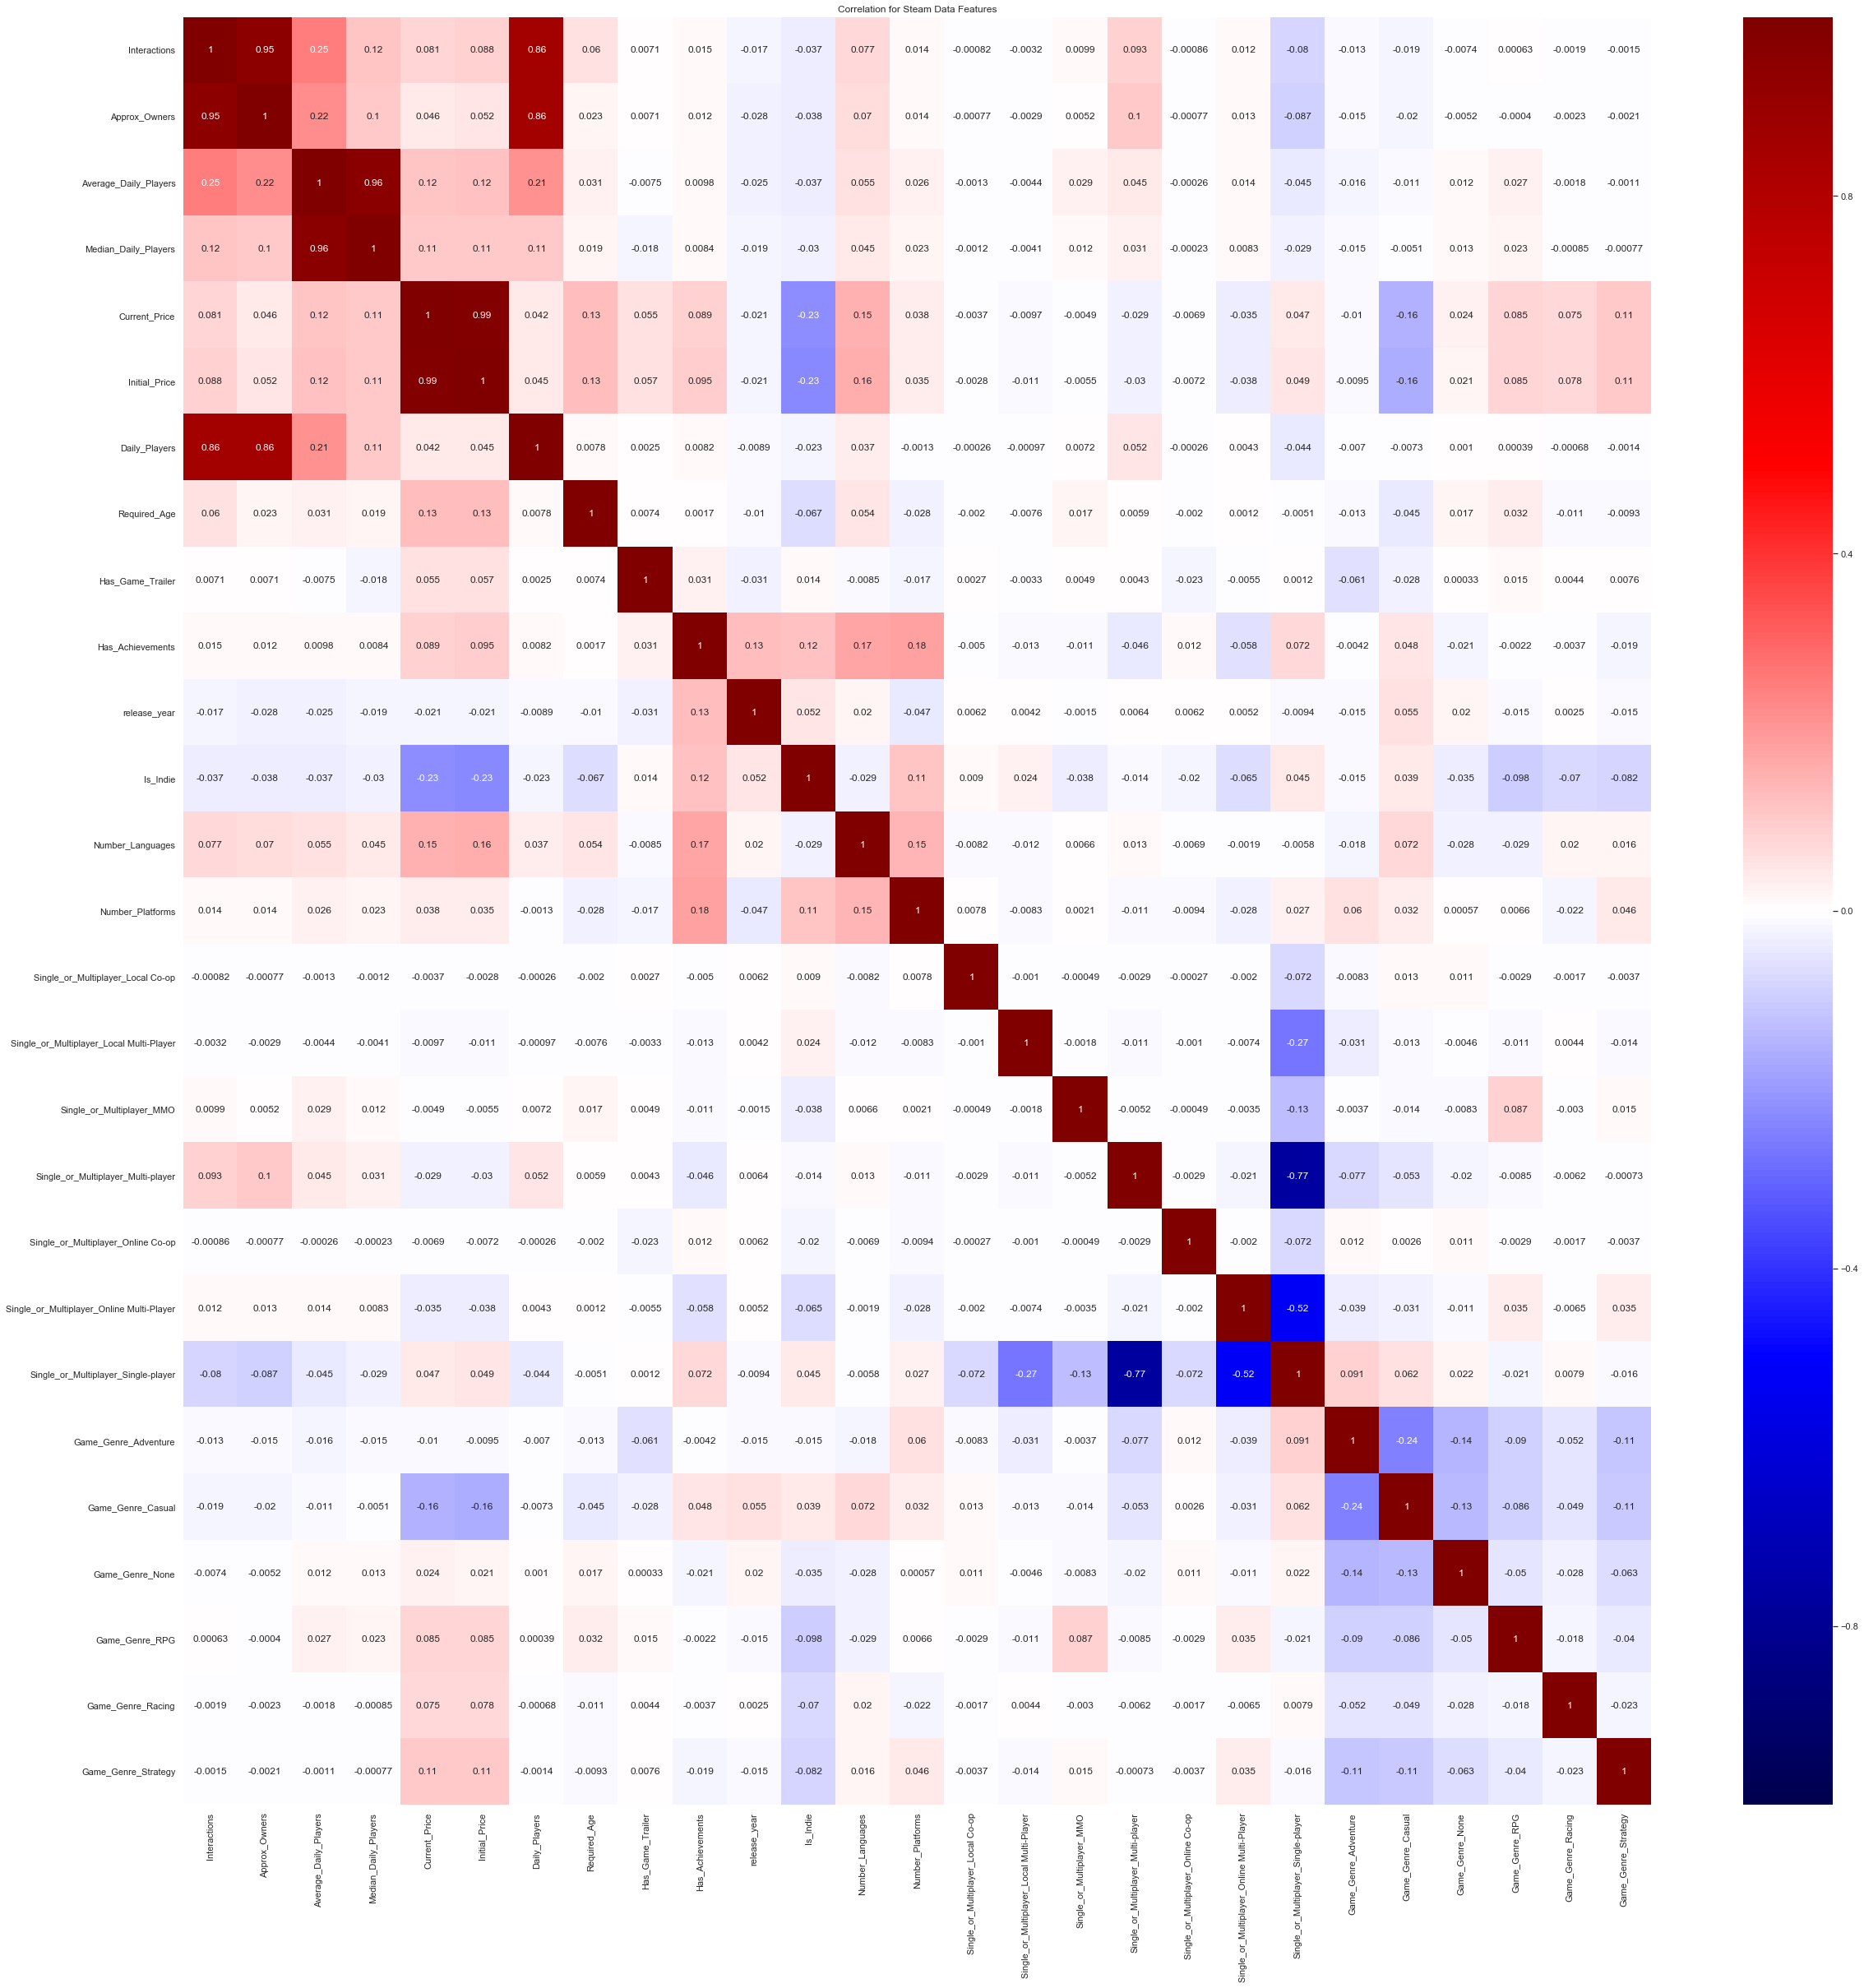

In [105]:
# example of a better corr matrix
sns.heatmap(two_years_steam_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

plt.rcParams['figure.figsize']=(40,40)
plt.title('Correlation for Steam Data Features')
plt.savefig('heatmap.svg')

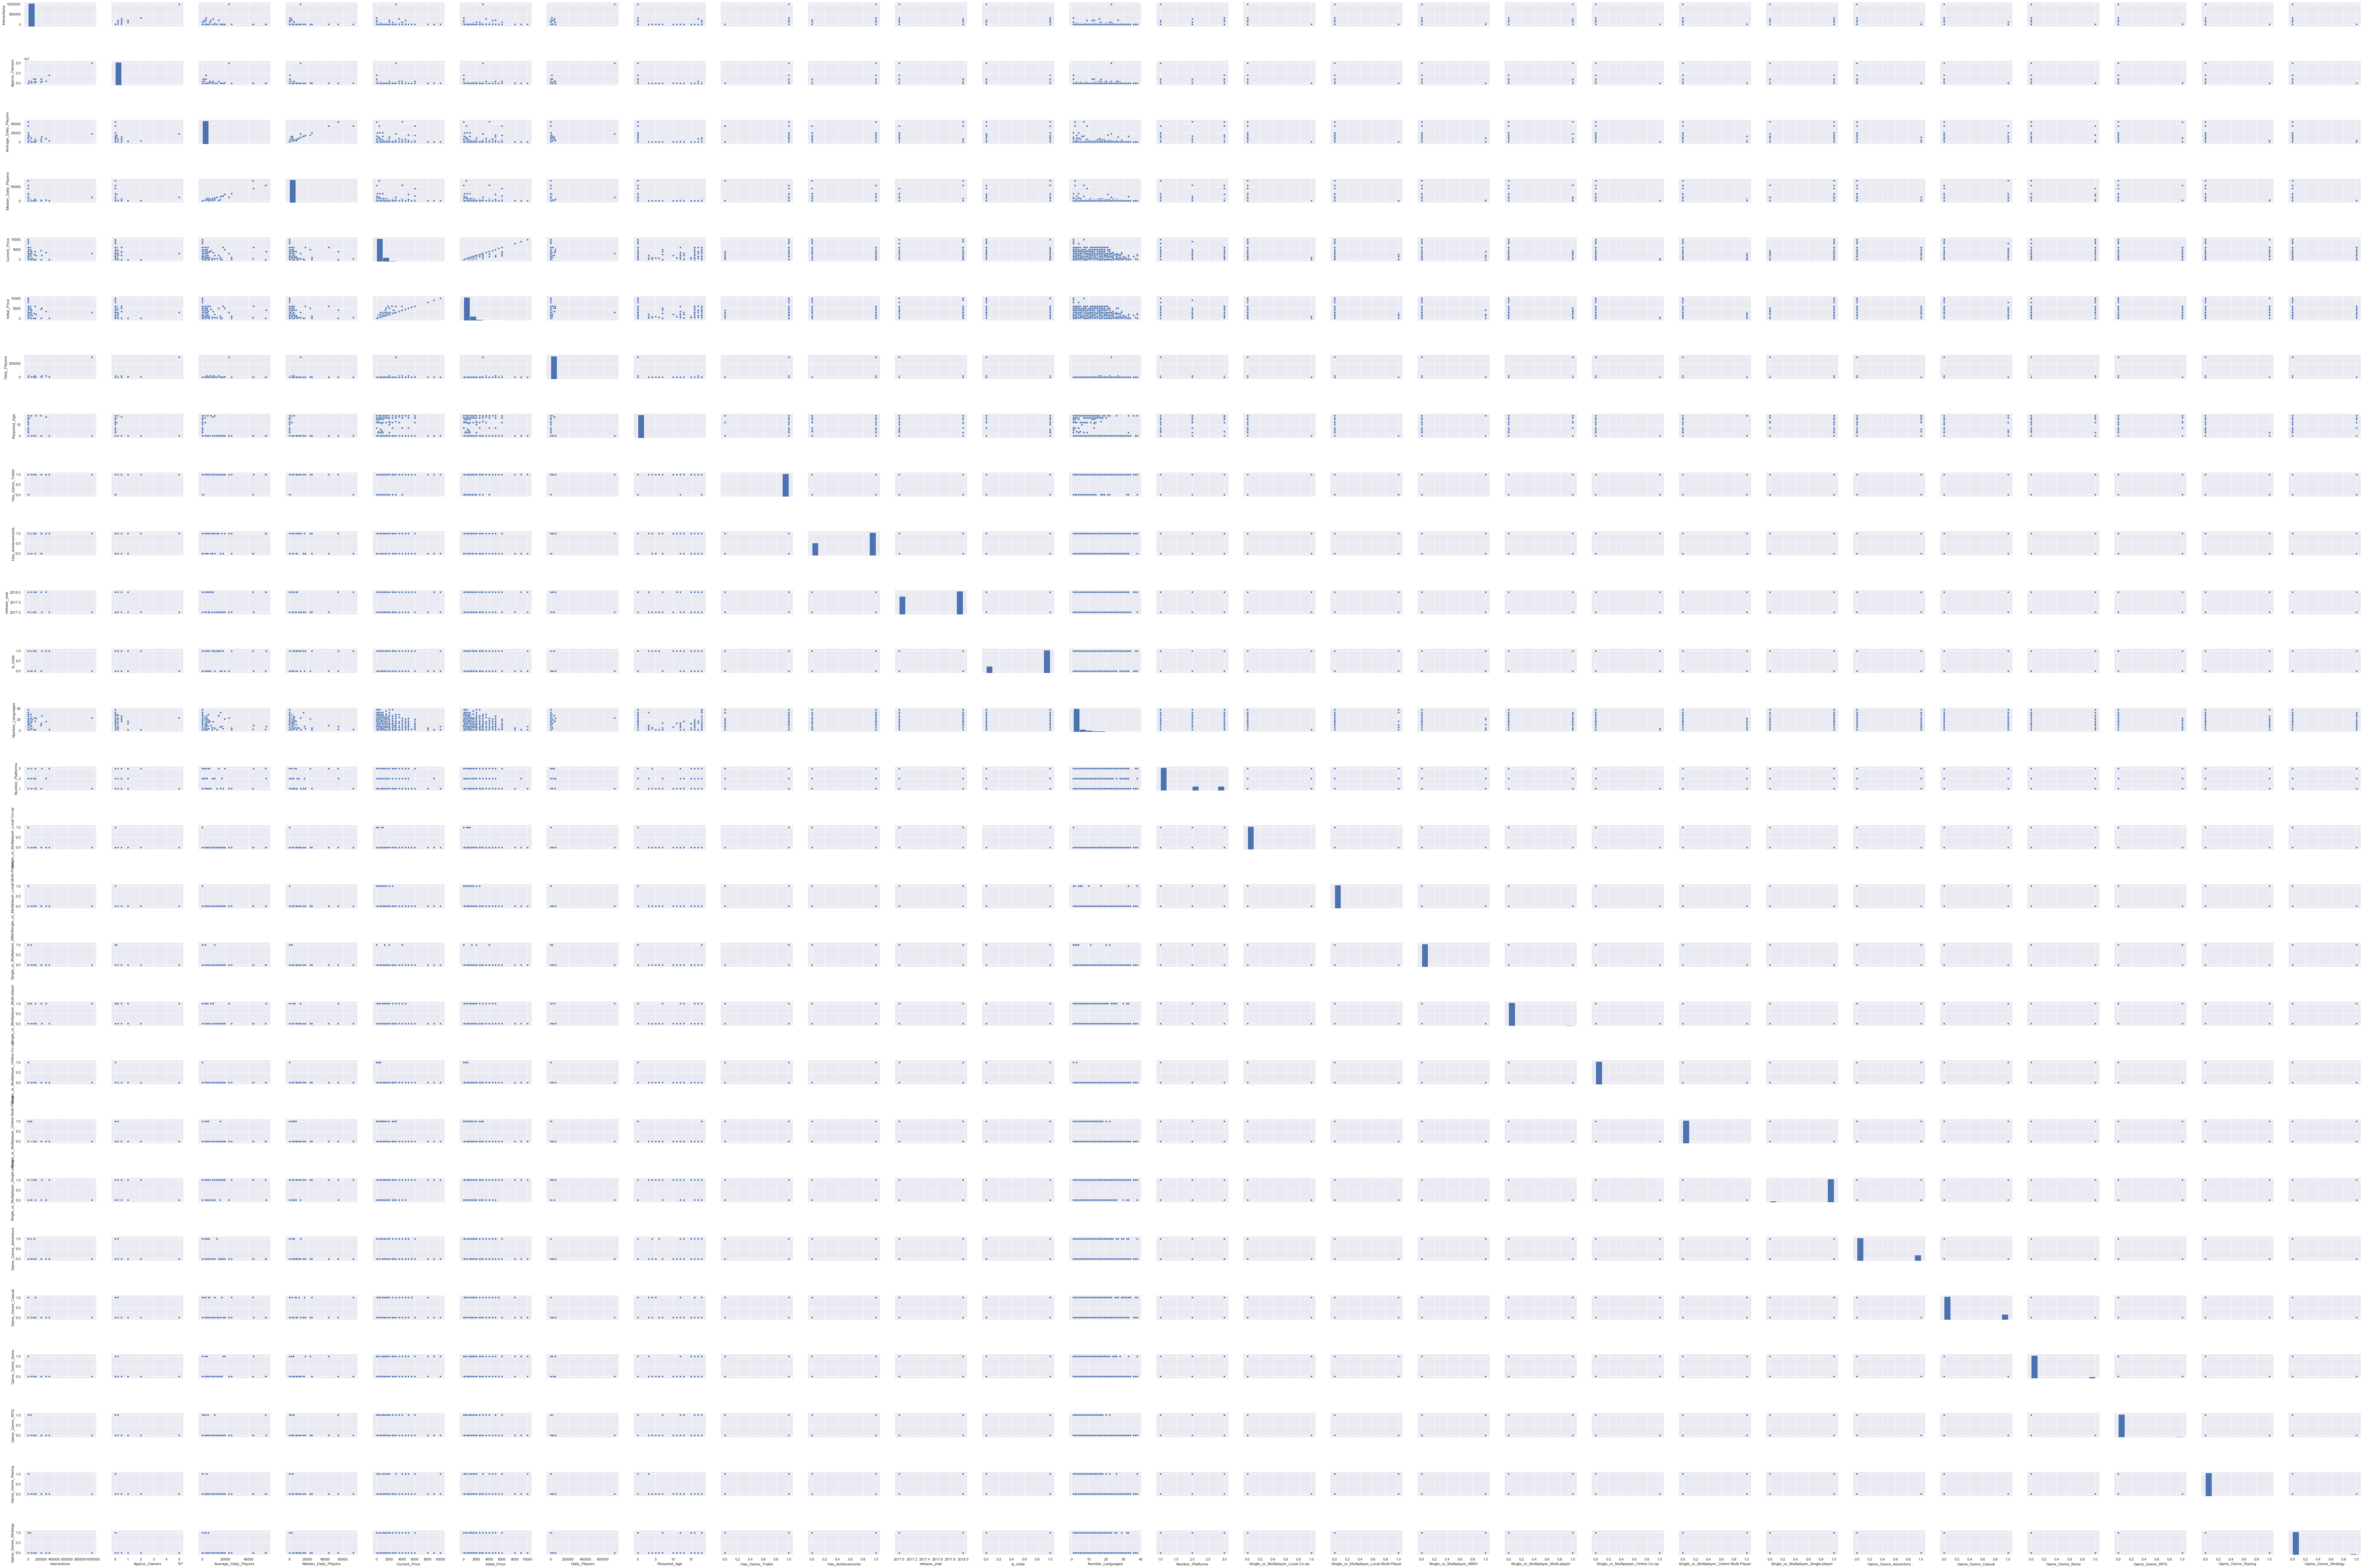

In [106]:
# Plot all of the variable-to-variable relations as scatterplots
plt.rcParams['figure.figsize']=(15,15)
sns.pairplot(two_years_steam_df, aspect=1.5);
plt.savefig('pairplot.svg')

In [355]:
two_years_steam_df.columns

Index(['Interactions', 'Approx_Owners', 'Average_Daily_Players',
       'Median_Daily_Players', 'Current_Price', 'Initial_Price',
       'Daily_Players', 'Required_Age', 'Has_Game_Trailer', 'Has_Achievements',
       'release_year', 'Is_Indie', 'Number_Languages', 'Number_Platforms',
       'Single_or_Multiplayer_Local Co-op',
       'Single_or_Multiplayer_Local Multi-Player', 'Single_or_Multiplayer_MMO',
       'Single_or_Multiplayer_Multi-player',
       'Single_or_Multiplayer_Online Co-op',
       'Single_or_Multiplayer_Online Multi-Player',
       'Single_or_Multiplayer_Single-player', 'Game_Genre_Adventure',
       'Game_Genre_Casual', 'Game_Genre_None', 'Game_Genre_RPG',
       'Game_Genre_Racing', 'Game_Genre_Strategy'],
      dtype='object')

In [356]:
two_years_steam_df.describe()

,Interactions,Approx_Owners,Average_Daily_Players,Median_Daily_Players,Current_Price,Initial_Price,Daily_Players,Required_Age,Has_Game_Trailer,Has_Achievements,...,Single_or_Multiplayer_Multi-player,Single_or_Multiplayer_Online Co-op,Single_or_Multiplayer_Online Multi-Player,Single_or_Multiplayer_Single-player,Game_Genre_Adventure,Game_Genre_Casual,Game_Genre_None,Game_Genre_RPG,Game_Genre_Racing,Game_Genre_Strategy
count,14817.000000,1.481700e+04,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,...,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000
mean,531.199366,2.807383e+04,79.126341,78.539650,697.323615,717.004387,97.561112,0.241479,0.973544,0.644935,...,0.029966,0.000270,0.013970,0.950597,0.203752,0.189175,0.071944,0.030843,0.010326,0.048188
std,9872.245789,4.946945e+05,1031.482020,1112.205712,828.787145,839.801491,6096.221312,1.981727,0.160493,0.478549,...,0.170498,0.016429,0.117372,0.216715,0.402801,0.391660,0.258405,0.172898,0.101094,0.214170
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000e+00,0.000000,0.000000,99.000000,99.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19.000000,0.000000e+00,0.000000,0.000000,499.000000,499.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,64.000000,0.000000e+00,0.000000,0.000000,999.000000,999.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,983260.000000,5.000000e+07,55204.000000,71857.000000,9999.000000,9999.000000,733670.000000,18.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [357]:
two_years_steam_df.Interactions.sort_values(ascending=False)

Game_Name
PLAYERUNKNOWN'S BATTLEGROUNDS           983260
Unturned                                324056
Rust                                    274079
ARK: Survival Evolved                   211638
Z1 Battle Royale                        203098
                                         ...  
bLogic Blox                                  0
Foundation of Nightmares                     0
Squirgle                                     0
Parabolus                                    0
The Man in the Cape: Special Edition         0
Name: Interactions, Length: 14817, dtype: int64

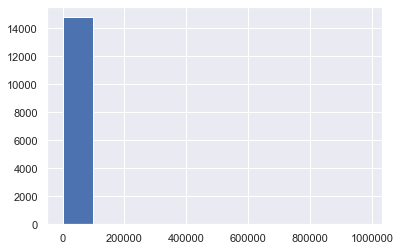

In [358]:
plt.hist(two_years_steam_df['Interactions']);

In [359]:
two_years_steam_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14817 entries, GROUND BRANCH to Roulette Simulator 2
Data columns (total 27 columns):
Interactions                                 14817 non-null int64
Approx_Owners                                14817 non-null int64
Average_Daily_Players                        14817 non-null int64
Median_Daily_Players                         14817 non-null int64
Current_Price                                14817 non-null float64
Initial_Price                                14817 non-null float64
Daily_Players                                14817 non-null int64
Required_Age                                 14817 non-null float64
Has_Game_Trailer                             14817 non-null int64
Has_Achievements                             14817 non-null int64
release_year                                 14817 non-null float64
Is_Indie                                     14817 non-null int64
Number_Languages                             14817 non-null int64
Num

In [360]:
# There appears to be a large deference between indie games and major developers as far as interactions are concerned. 
# Keep only the games with Indie tag

two_years_steam_df = two_years_steam_df[two_years_steam_df['Is_Indie'] == 1]
two_years_steam_df = two_years_steam_df.drop(columns=['Is_Indie'])

In [361]:
# Based on this scatter of interactions v daily players, interactions over 50000 appear to be outliers also daily
# players over 10000.  RETURN TO THIS IS THE MODEL IS NOT WORKING WELL

two_years_steam_df = two_years_steam_df[two_years_steam_df['Interactions'] > 0]
two_years_steam_df = two_years_steam_df[two_years_steam_df['Interactions'] < 50000]

(array([1.1114e+04, 6.1000e+01, 2.0000e+01, 6.0000e+00, 6.0000e+00,
        7.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([1.00000e+00, 4.21030e+03, 8.41960e+03, 1.26289e+04, 1.68382e+04,
        2.10475e+04, 2.52568e+04, 2.94661e+04, 3.36754e+04, 3.78847e+04,
        4.20940e+04]),
 <a list of 10 Patch objects>)

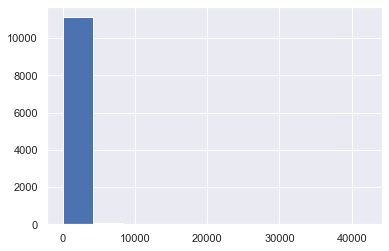

In [362]:
plt.hist(two_years_steam_df['Interactions'])

(array([1.1208e+04, 4.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0. ,  5520.4, 11040.8, 16561.2, 22081.6, 27602. , 33122.4,
        38642.8, 44163.2, 49683.6, 55204. ]),
 <a list of 10 Patch objects>)

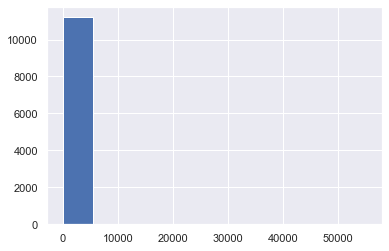

In [363]:
plt.hist(two_years_steam_df['Average_Daily_Players'])

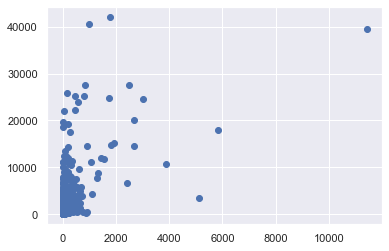

In [364]:
plt.scatter(two_years_steam_df['Daily_Players'], two_years_steam_df['Interactions'])

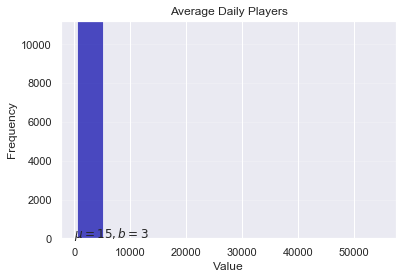

In [365]:
#plt.hist(two_years_steam_df['Daily_Players'], bins=[20])

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(two_years_steam_df['Average_Daily_Players'], bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Average Daily Players')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig('ave_daily_player.svg')

(array([1.1208e+04, 4.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0. ,  5520.4, 11040.8, 16561.2, 22081.6, 27602. , 33122.4,
        38642.8, 44163.2, 49683.6, 55204. ]),
 <a list of 10 Patch objects>)

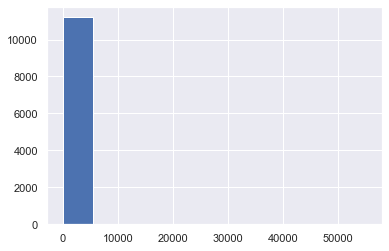

In [366]:
plt.hist(two_years_steam_df['Average_Daily_Players'])

In [367]:
two_years_steam_df.describe()

,Interactions,Approx_Owners,Average_Daily_Players,Median_Daily_Players,Current_Price,Initial_Price,Daily_Players,Required_Age,Has_Game_Trailer,Has_Achievements,...,Single_or_Multiplayer_Multi-player,Single_or_Multiplayer_Online Co-op,Single_or_Multiplayer_Online Multi-Player,Single_or_Multiplayer_Single-player,Game_Genre_Adventure,Game_Genre_Casual,Game_Genre_None,Game_Genre_RPG,Game_Genre_Racing,Game_Genre_Strategy
count,11220.000000,1.122000e+04,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,...,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000
mean,211.735829,1.288057e+04,55.723173,60.160606,594.959537,610.926649,9.969340,0.168271,0.974777,0.673708,...,0.028520,0.000089,0.009804,0.955971,0.201783,0.195544,0.066845,0.021747,0.006506,0.039127
std,1337.543544,8.729625e+04,860.742605,1020.424098,626.442753,630.932416,158.729868,1.654116,0.156808,0.468877,...,0.166462,0.009441,0.098533,0.205168,0.401349,0.396636,0.249764,0.145862,0.080402,0.193905
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000e+00,0.000000,0.000000,99.000000,99.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19.000000,0.000000e+00,0.000000,0.000000,399.000000,399.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59.000000,0.000000e+00,0.000000,0.000000,999.000000,999.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,42094.000000,5.000000e+06,55204.000000,71857.000000,9999.000000,9999.000000,11421.000000,18.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [368]:
two_years_steam_df["Median_Daily_Players"].value_counts()




0       9914
1         60
3         28
2         17
9         17
        ... 
2026       1
4019       1
1866       1
1738       1
1687       1
Name: Median_Daily_Players, Length: 528, dtype: int64

In [369]:
two_years_steam_df["Average_Daily_Players"].value_counts()



0       9914
1         60
3         25
2         20
9         19
        ... 
1325       1
1277       1
3292       1
1117       1
3958       1
Name: Average_Daily_Players, Length: 529, dtype: int64

## Baseline Linear Regression

In [370]:
X, y = two_years_steam_df.drop('Interactions',axis=1), two_years_steam_df['Interactions']

# Create model, fit it and print the summary stats
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Interactions   R-squared (uncentered):                   0.635
Model:                            OLS   Adj. R-squared (uncentered):              0.635
Method:                 Least Squares   F-statistic:                              780.6
Date:                Mon, 27 Jan 2020   Prob (F-statistic):                        0.00
Time:                        00:19:13   Log-Likelihood:                         -91166.
No. Observations:               11220   AIC:                                  1.824e+05
Df Residuals:                   11195   BIC:                                  1.826e+05
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Approx_Owners                                 0.0086   9.78e-05     87.524      0.000       0.008       0.009
Average_Daily_Players                        -0.1448      0.037     -3.906      0.000      -0.217      -0.072
Median_Daily_Players                          0.1374      0.031      4.420      0.000       0.076       0.198
Current_Price                                 0.8282      0.080     10.375      0.000       0.672       0.985
Initial_Price                                -0.6447      0.079     -8.120      0.000      -0.800      -0.489
Daily_Players                                 3.1473      0.054     58.762      0.000       3.042       3.252
Required_Age                                 14.6740      4.686      3.131      0.002       5.489      23.859
Has_Game_Trailer                             37.2647     49.682      0.750      0.453     -60.121     134.651
Has_Achievements                             39.9737     16.988      2.353      0.019       6.675      73.272
release_year                                 -0.0956      0.236     -0.405      0.685      -0.558       0.367
Number_Languages                              8.6356      1.238      6.974      0.000       6.208      11.063
Number_Platforms                             19.3845     10.767      1.800      0.072      -1.720      40.489
Single_or_Multiplayer_Local Co-op            61.3052    625.377      0.098      0.922   -1164.543    1287.153
Single_or_Multiplayer_Local Multi-Player    -38.0170    485.880     -0.078      0.938    -990.427     914.393
Single_or_Multiplayer_MMO                  -262.0719    669.597     -0.391      0.696   -1574.599    1050.455
Single_or_Multiplayer_Multi-player          156.1347    474.956      0.329      0.742    -774.862    1087.131
Single_or_Multiplayer_Online Co-op          -34.8831    945.297     -0.037      0.971   -1887.831    1818.065
Single_or_Multiplayer_Online Multi-Player   457.1687    479.183      0.954      0.340    -482.114    1396.451
Single_or_Multiplayer_Single-player          35.6023    472.724      0.075      0.940    -891.020     962.225
Game_Genre_Adventure                         25.2938     20.912      1.210      0.226     -15.698      66.285
Game_Genre_Casual                           -30.1974     21.391     -1.412      0.158     -72.127      11.732
Game_Genre_None                             -34.4004     32.054     -1.073      0.283     -97.231      28.431
Game_Genre_RPG                               -5.3881     53.880     -0.100      0.920    -111.003     100.226
Game_Genre_Racing                          -125.0597     96.532     -1.296      0.195    -314.279      64.160
Game_Genre_Str

## Split into Train, Validate, Test

In [468]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)


In [469]:
def run_kfold(X,y,ran_state,folds=5,shuffle_on=True):
    kf = KFold(folds,shuffle=shuffle_on,random_state=ran_state)
    r2 = defaultdict(list)
    rmse = defaultdict(list)
    mae = defaultdict(list)

    for train, test in kf.split(X,y):

        X_train, X_test = X.iloc[train],X.iloc[test]
        y_train, y_test = y.iloc[train],y.iloc[test]

        mean_cols = [x for x in X_train.columns if x[:4] == 'mean']
        sum_cols = [x for x in X_train.columns if x[:3] == 'sum']

        #scale
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_tr_scaled = scaler.transform(X_train)
        X_te_scaled = scaler.transform(X_test)

        #Instantiate
        lr = LinearRegression()
        l1 = Lasso()
        l2 = Ridge()

        #Fit
        lr.fit(X_train,y_train)
        l1.fit(X_tr_scaled,y_train)
        l2.fit(X_tr_scaled,y_train)

        #Predict
        lr_preds = lr.predict(X_test)
        l1_preds = l1.predict(X_te_scaled)
        l2_preds = l2.predict(X_te_scaled)

        #R2
        r2['lr'].append(lr.score(X_test,y_test))
        r2['l1'].append(l1.score(X_te_scaled,y_test))
        r2['l2'].append(l2.score(X_te_scaled,y_test))

        #RMSE
        rmse['lr'].append(np.sqrt(metrics.mean_squared_error(y_test,lr_preds)))
        rmse['l1'].append(np.sqrt(metrics.mean_squared_error(y_test,l1_preds)))
        rmse['l2'].append(np.sqrt(metrics.mean_squared_error(y_test,l2_preds)))

        #MAE
        mae['lr'].append(metrics.mean_absolute_error(y_test,lr_preds))
        mae['l1'].append(metrics.mean_absolute_error(y_test,l1_preds))
        mae['l2'].append(metrics.mean_absolute_error(y_test,l2_preds))
        
    for model in ['lr','l1','l2']:
        print(f'{model}: \n R2:{np.mean(r2[model])} RMSE:{np.mean(rmse[model])} MAE:{np.mean(mae[model])}')
        

In [470]:
run_kfold(X_train, y_train,ran_state=16)

lr: 
 R2:0.4826528004419705 RMSE:1012.1106507484021 MAE:224.76420240746324
l1: 
 R2:0.49924402417456737 RMSE:996.1163696588134 MAE:220.72138672583725
l2: 
 R2:0.4855247549389478 RMSE:1009.3788472893718 MAE:224.42535580750138


## Feature Engineering

In [471]:
def lasso_run(X_train, y_train, lasso_alpha=1):
    lasso_model = Lasso(alpha = lasso_alpha)
    lasso_model.fit(X_train, y_train)
    return list(zip(X_train.columns, lasso_model.coef_))

In [472]:
alphavec = 10**np.linspace(-2,2,5000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)

# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.07772811141188313

In [474]:
lasso_run(X_train, y_train, 0.07772811141188313)

[('Approx_Owners', 0.008946970021975292),
 ('Average_Daily_Players', -0.1512041219485063),
 ('Median_Daily_Players', 0.1379807629070172),
 ('Current_Price', 1.1237006058737948),
 ('Initial_Price', -0.9355359666038333),
 ('Daily_Players', 3.110411005199399),
 ('Required_Age', 11.813682279102045),
 ('Has_Game_Trailer', 35.18031962060901),
 ('Has_Achievements', 54.288053095615865),
 ('release_year', -15.338592968061256),
 ('Number_Languages', 8.92440922277523),
 ('Number_Platforms', 13.801878586719935),
 ('Single_or_Multiplayer_Local Co-op', 0.0),
 ('Single_or_Multiplayer_Local Multi-Player', -77.04088997111978),
 ('Single_or_Multiplayer_MMO', -74.9648513961644),
 ('Single_or_Multiplayer_Multi-player', 169.14160954011328),
 ('Single_or_Multiplayer_Online Co-op', -0.0),
 ('Single_or_Multiplayer_Online Multi-Player', 437.24030599200955),
 ('Single_or_Multiplayer_Single-player', 0.0),
 ('Game_Genre_Adventure', 24.096014334836752),
 ('Game_Genre_Casual', -35.96521255116264),
 ('Game_Genre_Non

In [475]:
# combine single_or_multiplayer into two columns of single or multiplayer by dropping all multiplayer rows

run_2_df = two_years_steam_df.drop(columns=['Single_or_Multiplayer_Local Co-op','Single_or_Multiplayer_Local Co-op','Single_or_Multiplayer_MMO','Single_or_Multiplayer_Multi-player', 'Single_or_Multiplayer_Online Co-op','Single_or_Multiplayer_Online Multi-Player','Single_or_Multiplayer_Local Multi-Player'])
X_test = X_test.drop(columns=['Single_or_Multiplayer_Local Co-op','Single_or_Multiplayer_Local Co-op','Single_or_Multiplayer_MMO','Single_or_Multiplayer_Multi-player', 'Single_or_Multiplayer_Online Co-op','Single_or_Multiplayer_Online Multi-Player','Single_or_Multiplayer_Local Multi-Player'])


In [476]:
X_train, y_train = run_2_df.drop('Interactions',axis=1), run_2_df['Interactions']

In [477]:
run_kfold(X_train, y_train,ran_state=16)

lr: 
 R2:0.3428470341530005 RMSE:1006.7513511552901 MAE:205.8370557765424
l1: 
 R2:0.3656579753085515 RMSE:990.1308893587751 MAE:202.53504708216138
l2: 
 R2:0.3452674362963428 RMSE:1004.9866140565894 MAE:205.6881784962755


In [479]:
lasso_run(X_train, y_train, 0.07772811141188313)

[('Approx_Owners', 0.008553336435067041),
 ('Average_Daily_Players', -0.14624179942031948),
 ('Median_Daily_Players', 0.13857876401033728),
 ('Current_Price', 0.82983371766503),
 ('Initial_Price', -0.646952373583915),
 ('Daily_Players', 3.149599194944234),
 ('Required_Age', 14.836065529931204),
 ('Has_Game_Trailer', 31.51571473419338),
 ('Has_Achievements', 39.784340621894586),
 ('release_year', -14.858362305623869),
 ('Number_Languages', 8.698807869386814),
 ('Number_Platforms', 17.92000875030324),
 ('Single_or_Multiplayer_Single-player', -160.92753043183535),
 ('Game_Genre_Adventure', 26.266607825978994),
 ('Game_Genre_Casual', -28.52768764935576),
 ('Game_Genre_None', -31.352047073036996),
 ('Game_Genre_RPG', -0.0),
 ('Game_Genre_Racing', -112.5928910154523),
 ('Game_Genre_Strategy', -87.24961426454617)]

In [480]:
# Reduced R2 by .001 . Probably not worth having the 5 extra columns
# Now remove Genre since as the coef from the lasso are all 0.  Also remove single player

#run_3_df = run_2_df.drop(columns=['Game_Genre_Adventure','Game_Genre_Casual','Game_Genre_None','Game_Genre_Strategy','Game_Genre_RPG','Game_Genre_Racing'])
#X_test = X_test.drop(columns=['Game_Genre_Adventure','Game_Genre_Casual','Game_Genre_None','Game_Genre_Strategy','Game_Genre_RPG','Game_Genre_Racing'])


In [481]:
#run_3_df.head(2)

In [482]:
#X_train, y_train = run_3_df.drop('Interactions',axis=1), run_2_df['Interactions']

In [483]:
#run_kfold(X_train, y_train,ran_state=16)

In [484]:
# Another small decrease in R2 of .005

#lasso_run(X_train, y_train, 0.07770433044524377)


In [485]:
# Remove release year as that was to just identify which two years it was launched

run_3_df = run_2_df.drop(columns=['release_year'])
X_test = X_test.drop(columns=['release_year'])


In [486]:
X_train, y_train = run_3_df.drop('Interactions',axis=1), run_3_df['Interactions']

In [487]:
run_kfold(X_train, y_train,ran_state=16)

lr: 
 R2:0.343638528756714 RMSE:1006.2688197166372 MAE:205.31855885185638
l1: 
 R2:0.3663804637053402 RMSE:989.684047322335 MAE:202.06293868038392
l2: 
 R2:0.346056076380537 RMSE:1004.5055646734576 MAE:205.1689807540084


In [488]:
lasso_run(X_train, y_train, .01)

[('Approx_Owners', 0.008559157975151074),
 ('Average_Daily_Players', -0.14552370374030518),
 ('Median_Daily_Players', 0.1381353251961002),
 ('Current_Price', 0.8303410107884606),
 ('Initial_Price', -0.647431462875535),
 ('Daily_Players', 3.1478802337326823),
 ('Required_Age', 14.898353424255879),
 ('Has_Game_Trailer', 36.46040038070677),
 ('Has_Achievements', 38.22608338937001),
 ('Number_Languages', 8.684956022757376),
 ('Number_Platforms', 18.919944800213496),
 ('Single_or_Multiplayer_Single-player', -161.53908543103174),
 ('Game_Genre_Adventure', 25.995324252106474),
 ('Game_Genre_Casual', -30.26091507091206),
 ('Game_Genre_None', -33.66353412377063),
 ('Game_Genre_RPG', -2.7750835579716235),
 ('Game_Genre_Racing', -123.90428217701654),
 ('Game_Genre_Strategy', -89.78822018119081)]

In [489]:
# A slight improvement when combining the two columns.  Will drop the original and keep the combined one for now.  
# Combing languages and number of platforms

#run_2_df = run_2_df.drop(columns=['Has_Achievements','Has_Game_Trailer'])

run_3_df['Lang_Plat'] = run_3_df['Number_Languages'] * run_3_df['Number_Platforms']
X_test['Lang_Plat'] = X_test['Number_Languages'] * X_test['Number_Platforms']

In [490]:
X_train, y_train = run_3_df.drop('Interactions',axis=1), run_3_df['Interactions']
run_kfold(X_train, y_train,ran_state=16)

lr: 
 R2:0.342857225793716 RMSE:1006.7095473044513 MAE:205.33279164108635
l1: 
 R2:0.3657902365511291 RMSE:989.9879296047193 MAE:201.94230837865152
l2: 
 R2:0.3452836651401263 RMSE:1004.941342392662 MAE:205.18221209289345


In [491]:
lasso_run(X_train, y_train, 0.07770433044524377)

[('Approx_Owners', 0.008560788985773941),
 ('Average_Daily_Players', -0.14540976109067333),
 ('Median_Daily_Players', 0.13803543377771998),
 ('Current_Price', 0.830122004391922),
 ('Initial_Price', -0.6472917322794183),
 ('Daily_Players', 3.148085472483154),
 ('Required_Age', 14.853033561544041),
 ('Has_Game_Trailer', 32.983854962616014),
 ('Has_Achievements', 37.78555415245441),
 ('Number_Languages', 9.207121697186421),
 ('Number_Platforms', 20.30525338038746),
 ('Single_or_Multiplayer_Single-player', -159.86177199133465),
 ('Game_Genre_Adventure', 25.8598531601445),
 ('Game_Genre_Casual', -29.393284161626156),
 ('Game_Genre_None', -32.21826724971938),
 ('Game_Genre_RPG', -0.0),
 ('Game_Genre_Racing', -113.41349991040802),
 ('Game_Genre_Strategy', -87.52590657712743),
 ('Lang_Plat', -0.31050130903506484)]

In [492]:
run_2_df.describe()

,Interactions,Approx_Owners,Average_Daily_Players,Median_Daily_Players,Current_Price,Initial_Price,Daily_Players,Required_Age,Has_Game_Trailer,Has_Achievements,release_year,Number_Languages,Number_Platforms,Single_or_Multiplayer_Single-player,Game_Genre_Adventure,Game_Genre_Casual,Game_Genre_None,Game_Genre_RPG,Game_Genre_Racing,Game_Genre_Strategy
count,11220.000000,1.122000e+04,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000,11220.000000
mean,211.735829,1.288057e+04,55.723173,60.160606,594.959537,610.926649,9.969340,0.168271,0.974777,0.673708,2017.575045,4.049643,1.454011,0.955971,0.201783,0.195544,0.066845,0.021747,0.006506,0.039127
std,1337.543544,8.729625e+04,860.742605,1020.424098,626.442753,630.932416,158.729868,1.654116,0.156808,0.468877,0.494358,6.487925,0.743829,0.205168,0.401349,0.396636,0.249764,0.145862,0.080402,0.193905
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000e+00,0.000000,0.000000,99.000000,99.000000,0.000000,0.000000,1.000000,0.000000,2017.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19.000000,0.000000e+00,0.000000,0.000000,399.000000,399.000000,0.000000,0.000000,1.000000,1.000000,2018.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59.000000,0.000000e+00,0.000000,0.000000,999.000000,999.000000,0.000000,0.000000,1.000000,1.000000,2018.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,42094.000000,5.000000e+06,55204.000000,71857.000000,9999.000000,9999.000000,11421.000000,18.000000,1.000000,1.000000,2018.000000,38.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [493]:
X_train.columns

Index(['Approx_Owners', 'Average_Daily_Players', 'Median_Daily_Players',
       'Current_Price', 'Initial_Price', 'Daily_Players', 'Required_Age',
       'Has_Game_Trailer', 'Has_Achievements', 'Number_Languages',
       'Number_Platforms', 'Single_or_Multiplayer_Single-player',
       'Game_Genre_Adventure', 'Game_Genre_Casual', 'Game_Genre_None',
       'Game_Genre_RPG', 'Game_Genre_Racing', 'Game_Genre_Strategy',
       'Lang_Plat'],
      dtype='object')

In [494]:
X_test = X_test[['Approx_Owners', 'Average_Daily_Players', 'Median_Daily_Players',
       'Current_Price', 'Initial_Price', 'Daily_Players', 'Required_Age',
       'Has_Game_Trailer', 'Has_Achievements', 'Number_Languages',
       'Number_Platforms', 'Single_or_Multiplayer_Single-player',
       'Game_Genre_Adventure', 'Game_Genre_Casual', 'Game_Genre_None',
       'Game_Genre_RPG', 'Game_Genre_Racing', 'Game_Genre_Strategy',
       'Lang_Plat']]

In [495]:
X_test.head(2)

,Approx_Owners,Average_Daily_Players,Median_Daily_Players,Current_Price,Initial_Price,Daily_Players,Required_Age,Has_Game_Trailer,Has_Achievements,Number_Languages,Number_Platforms,Single_or_Multiplayer_Single-player,Game_Genre_Adventure,Game_Genre_Casual,Game_Genre_None,Game_Genre_RPG,Game_Genre_Racing,Game_Genre_Strategy,Lang_Plat
Game_Name,,,,,,,,,,,,,,,,,,,
Ambers BOOM,0,0,0,199.0,199.0,0,0.0,1,0,2,1,1,1,0,0,0,0,0,2
Delta Horizon,0,0,0,0.0,0.0,0,0.0,0,0,1,1,0,0,0,0,0,0,0,1


In [496]:


# Create model, fit it and print the summary stats
model = sm.OLS(y_train, X_train)
fit = model.fit()
y_pred = fit.predict(X_test)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Interactions   R-squared (uncentered):                   0.635
Model:                            OLS   Adj. R-squared (uncentered):              0.634
Method:                 Least Squares   F-statistic:                              1025.
Date:                Mon, 27 Jan 2020   Prob (F-statistic):                        0.00
Time:                        00:54:49   Log-Likelihood:                         -91175.
No. Observations:               11220   AIC:                                  1.824e+05
Df Residuals:                   11201   BIC:                                  1.825e+05
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Approx_Owners                           0.0086   9.75e-05     87.802      0.000       0.008       0.009
Average_Daily_Players                  -0.1457      0.037     -3.929      0.000      -0.218      -0.073
Median_Daily_Players                    0.1383      0.031      4.447      0.000       0.077       0.199
Current_Price                           0.8303      0.080     10.398      0.000       0.674       0.987
Initial_Price                          -0.6474      0.079     -8.152      0.000      -0.803      -0.492
Daily_Players                           3.1483      0.054     58.730      0.000       3.043       3.253
Required_Age                           14.8807      4.689      3.173      0.002       5.689      24.072
Has_Game_Trailer                       39.0301     32.706      1.193      0.233     -25.079     103.139
Has_Achievements                       38.2092     16.954      2.254      0.024       4.977      71.442
Number_Languages                        9.2537      2.682      3.450      0.001       3.996      14.512
Number_Platforms                       20.7915     12.527      1.660      0.097      -3.764      45.347
Single_or_Multiplayer_Single-player  -160.1036     32.248     -4.965      0.000    -223.314     -96.893
Game_Genre_Adventure                   25.9014     20.876      1.241      0.215     -15.019      66.822
Game_Genre_Casual                     -30.1579     21.336     -1.413      0.158     -71.981      11.665
Game_Genre_None                       -33.8533     32.045     -1.056      0.291     -96.668      28.961
Game_Genre_RPG                         -3.4459     53.749     -0.064      0.949    -108.804     101.912
Game_Genre_Racing                    -125.7334     96.567     -1.302      0.193    -315.022      63.555
Game_Genre_Strategy                   -90.1021     40.995     -2.198      0.028    -170.459      -9.745
Lang_Plat                              -0.3374      1.415     -0.238      0.812      -3.111       2.436
==============================================================================
Omnibus:                    15153.470   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        178613579.960
Skew:                           6.349   Prob(JB):                         0.00
Kurtosis:                     620.981   Cond. No.                     1.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numeri

In [497]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})



In [498]:
result_df['residuals'] = result_df['Actual'] - result_df['Predicted']




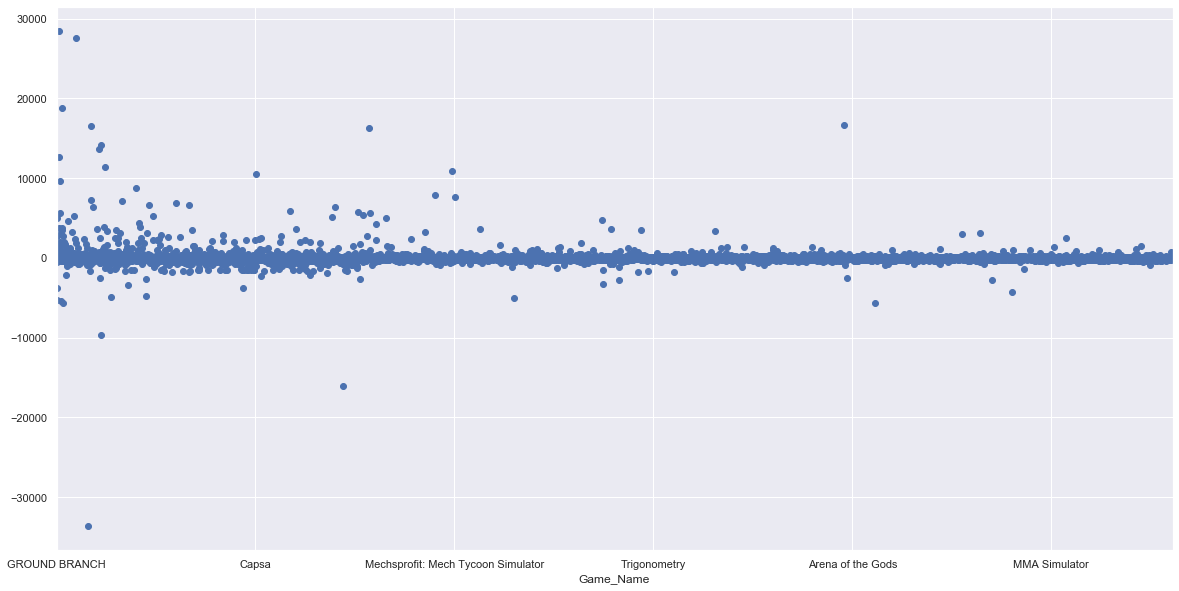

In [500]:
fit.resid.plot(style='o', figsize=(20,10))



For the most part, the residual plot indicates that the majority of the predictions are clustered along 0 but the scale is large due to the extreme outliers.  

In [501]:
r2 = defaultdict(list)
rmse = defaultdict(list)
mae = defaultdict(list)

#Instantiate
lr = LinearRegression()


#Fit
lr.fit(X_train,y_train)


#Predict
lr_preds = lr.predict(X_test)

#R2
r2['lr'].append(lr.score(X_test,y_test))


#RMSE
rmse['lr'].append(np.sqrt(metrics.mean_squared_error(y_test,lr_preds)))


#MAE
mae['lr'].append(metrics.mean_absolute_error(y_test,lr_preds))

for model in ['lr']:
    print(f'{model}: \n R2:{np.mean(r2[model])} RMSE:{np.mean(rmse[model])} MAE:{np.mean(mae[model])}')

lr: 
 R2:0.5644696408031125 RMSE:488.1858522200999 MAE:169.54548119342027


In [502]:
# Create model, fit it and print the summary stats
model = sm.OLS(y_train, X_train)
fit = model.fit()
fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Interactions   R-squared (uncentered):                   0.635
Model:                            OLS   Adj. R-squared (uncentered):              0.634
Method:                 Least Squares   F-statistic:                              1025.
Date:                Mon, 27 Jan 2020   Prob (F-statistic):                        0.00
Time:                        00:55:05   Log-Likelihood:                         -91175.
No. Observations:               11220   AIC:                                  1.824e+05
Df Residuals:                   11201   BIC:                                  1.825e+05
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Approx_Owners                           0.0086   9.75e-05     87.802      0.000       0.008       0.009
Average_Daily_Players                  -0.1457      0.037     -3.929      0.000      -0.218      -0.073
Median_Daily_Players                    0.1383      0.031      4.447      0.000       0.077       0.199
Current_Price                           0.8303      0.080     10.398      0.000       0.674       0.987
Initial_Price                          -0.6474      0.079     -8.152      0.000      -0.803      -0.492
Daily_Players                           3.1483      0.054     58.730      0.000       3.043       3.253
Required_Age                           14.8807      4.689      3.173      0.002       5.689      24.072
Has_Game_Trailer                       39.0301     32.706      1.193      0.233     -25.079     103.139
Has_Achievements                       38.2092     16.954      2.254      0.024       4.977      71.442
Number_Languages                        9.2537      2.682      3.450      0.001       3.996      14.512
Number_Platforms                       20.7915     12.527      1.660      0.097      -3.764      45.347
Single_or_Multiplayer_Single-player  -160.1036     32.248     -4.965      0.000    -223.314     -96.893
Game_Genre_Adventure                   25.9014     20.876      1.241      0.215     -15.019      66.822
Game_Genre_Casual                     -30.1579     21.336     -1.413      0.158     -71.981      11.665
Game_Genre_None                       -33.8533     32.045     -1.056      0.291     -96.668      28.961
Game_Genre_RPG                         -3.4459     53.749     -0.064      0.949    -108.804     101.912
Game_Genre_Racing                    -125.7334     96.567     -1.302      0.193    -315.022      63.555
Game_Genre_Strategy                   -90.1021     40.995     -2.198      0.028    -170.459      -9.745
Lang_Plat                              -0.3374      1.415     -0.238      0.812      -3.111       2.436
==============================================================================
Omnibus:                    15153.470   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        178613579.960
Skew:                           6.349   Prob(JB):                         0.00
Kurtosis:                     620.981   Cond. No.                     1.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numeri

In [503]:
steam_df.describe()



,Interactions,Approx_Owners,Average_Daily_Players,Median_Daily_Players,Current_Price,Initial_Price,Daily_Players,Required_Age,Has_Game_Trailer,Has_Achievements,release_year,Is_Indie,Number_Languages,Number_Platforms
count,2.775500e+04,2.775500e+04,27755.000000,27755.000000,27755.000000,27755.000000,27755.000000,27755.000000,27755.000000,27755.000000,27755.000000,27755.000000,27755.000000,27755.000000
mean,1.209351e+03,8.104594e+04,147.652891,143.830013,750.692848,775.583174,146.281103,0.422374,0.935867,0.630229,2016.479986,0.719438,4.264601,1.489714
std,2.216805e+04,8.644640e+05,1804.680947,2324.580167,832.246750,844.951426,7074.185047,11.170564,0.244993,0.482751,2.187059,0.449282,6.076168,0.767902
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.000000,0.000000,1.000000,1.000000
25%,1.000000e+01,0.000000e+00,0.000000,0.000000,199.000000,199.000000,0.000000,0.000000,1.000000,0.000000,2016.000000,0.000000,1.000000,1.000000
50%,3.500000e+01,0.000000e+00,0.000000,0.000000,499.000000,499.000000,0.000000,0.000000,1.000000,1.000000,2017.000000,1.000000,1.000000,1.000000
75%,1.770000e+02,2.000000e+04,0.000000,0.000000,999.000000,999.000000,0.000000,0.000000,1.000000,1.000000,2018.000000,1.000000,5.000000,2.000000
max,3.046717e+06,1.000000e+08,190625.000000,190625.000000,9999.000000,9999.000000,742725.000000,1818.000000,1.000000,1.000000,2019.000000,1.000000,38.000000,3.000000


In [504]:
X_test.columns



Index(['Approx_Owners', 'Average_Daily_Players', 'Median_Daily_Players',
       'Current_Price', 'Initial_Price', 'Daily_Players', 'Required_Age',
       'Has_Game_Trailer', 'Has_Achievements', 'Number_Languages',
       'Number_Platforms', 'Single_or_Multiplayer_Single-player',
       'Game_Genre_Adventure', 'Game_Genre_Casual', 'Game_Genre_None',
       'Game_Genre_RPG', 'Game_Genre_Racing', 'Game_Genre_Strategy',
       'Lang_Plat'],
      dtype='object')

In [569]:
# Time to make the prediction using the variables and expected variables of the game. 

X_our_game = pd.DataFrame({'Approx_Owners': 20000, 'Average_Daily_Players':20, 'Median_Daily_Players':20,
       'Current_Price':2999, 'Initial_Price':999, 'Daily_Players':20,
       'Required_Age':17, 'Has_Game_Trailer': 1, 'Has_Achievements': 1,'Number_Languages':4,'Number_Platforms':3, 'Single_or_Multiplayer_Single-player':0,
       'Game_Genre_Adventure':0, 'Game_Genre_Casual':0, 'Game_Genre_None':0,
       'Game_Genre_RPG':1, 'Game_Genre_Racing':0, 'Game_Genre_Strategy':0,
       'Lang_Plat':12}, index={'Game_Name':'Super Ninja Space Cats of Data Science'})


In [570]:
lr_preds = lr.predict(X_our_game)

In [572]:
# The prediction indicates that we should expect 2500 interactions in a 1 to 2 year period.  

lr_preds

array([2500.42751134])

In [573]:
lr.coef_

array([ 8.55983347e-03, -1.45585366e-01,  1.38181646e-01,  8.30232970e-01,
       -6.47386438e-01,  3.14838459e+00,  1.48780881e+01,  3.61562585e+01,
        3.81129669e+01,  9.23252114e+00,  2.05609845e+01, -1.61706775e+02,
        2.57886059e+01, -3.02813397e+01, -3.39369973e+01, -3.52057361e+00,
       -1.25900645e+02, -9.01625085e+01, -3.25468217e-01])

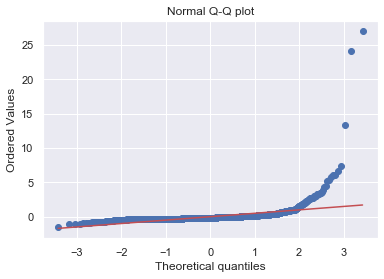

<Figure size 432x288 with 0 Axes>

In [574]:
import scipy.stats as stats

z = (y_pred-np.mean(y_pred))/np.std(y_pred)

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()
plt.savefig('QQplot.svg')